# Counting Wikipedia 'langlinks' for classical authors

This notebook answers a question I have been curious about for a while now, coming initially after I posted the following on Twitter: 

<blockquote class="twitter-tweet" data-lang="en"><p lang="ca" dir="ltr">Wikipedia has Homer articles in ~147 languages. (Hesiod 63, Apollonius of Rhodes 40, Lucretius 57, Virgil 125, Ovid 99, Lucan 44)</p>&mdash; Patrick J. Burns (@diyclassics) <a href="https://twitter.com/diyclassics/status/459325466756014081?ref_src=twsrc%5Etfw">April 24, 2014</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

The question here is which classical authors have the best language coverage on Wikipedia. It turns out that this is fairly straightforward to determine using the Mediawiki API. The code below takes you from a list of authors to a count of what Wikipedia calls "langlinks" to basic visualizations of the results.

For the list of classical authors, I used information from the [Loeb Classical Library "Timeline of Authors"](http://www.hup.harvard.edu/features/loeb/timeline.html). This required some data cleaning to handle Wikipedia's system for resolving ambiguity. For example, "Cato" was not a specific enough search term, yielding not the page for ["Cato the Elder"](https://en.wikipedia.org/wiki/Cato_the_Elder), but rather the [disambiguation page for the word 'Cato'](https://en.wikipedia.org/wiki/Cato). (If you notice any ambiguous terms that I have missed, let me know and I will update the results.)

These terms were then run through the [Mediawiki API](https://www.mediawiki.org/wiki/API:Main_page), returning a json object that includes the ```langlink``` info. Note that langlink queries are limited by default to 10; I raised the maximum to 250 for this study. The number of langlinks for each term were counted and added to a list of tuples with this following structure: [(term1, lang1, count1), (term2, lang2, count2,) ...].

Here is a summary of the results:

```
156 authors
94 Greek authors
62 Latin authors

Max value: ('Julius_Caesar', 'Latin', 199)
Min value: ('Coluthus', 'Greek', 9)
Avg value: 51.73076923076923

Greek Max value: ('Aristotle', 'Greek', 185)
Greek Min value: ('Coluthus', 'Greek', 9)
Greek Avg value: 50.180851063829785

Latin Max value: ('Julius_Caesar', 'Latin', 199)
Latin Min value: ('Caecilius_Statius', 'Latin', 20)
Latin Avg value: 54.08064516129032
```

My guess going into this was that Homer or Plato or Aristotle would have had the most number of pages. But with the results in, I am hardly surprised to see [Julius Caesar](https://en.wikipedia.org/wiki/Julius_Caesar) at the top of the list—though hardly for his ["literary work"](https://en.wikipedia.org/wiki/Julius_Caesar#Literary_works) which make up only a small percentage of a rather large Wikipedia article. (Augustus is the second ranked Latin author for substantially similar reasons.) For Greek, Homer, Plato, and Aristotle all crack the top 10, as do Euclid, Sophocles and Herodotus; for Latin, Virgil and Augustine.

Language representation in Wikipedia perhaps give us a sense of the relative, for lack of a better word, popularity of classical authors on an international scale. Perhaps not. It is worth noting that for, to take one example, [Tryphiodorus](https://en.wikipedia.org/wiki/Tryphiodorus), the Greek author with the fewest langlinks, although he has articles in Bulgarian, Catalan, English, Finnish, French, German, Greek, Italian, and Polish, most of these articles are very short (Englsh, Greek, and Italian being the exceptions here). With this is mind, it would be interesting to continue this line of investigation by comparing average article length by language. \[PJB 3.12.2018\; update 7.15.2020]


In [1]:
# Import

import requests

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from pprint import pprint

In [2]:
# List based on http://www.hup.harvard.edu/features/loeb/timeline.html
# Hand-corrected to handle wikipedia disambiguation; I think I caught them all—let me know if you notice anything.

authors = [('Achilles Tatius', 'Greek'), ('Aeneas Tacticus', 'Greek'), ('Aeschines', 'Greek'), ('Aeschylus', 'Greek'), ('Alcaeus_of_Mytilene', 'Greek'), ('Alciphron', 'Greek'), ('Alcman', 'Greek'), ('Ammianus Marcellinus', 'Latin'), ('Anacreon', 'Greek'), ('Andocides', 'Greek'), ('Antiphon', 'Greek'), ('Apollodorus_of_Athens', 'Greek'), ('Apollonius_of_Rhodes', 'Greek'), ('Appian', 'Greek'), ('Apuleius', 'Latin'), ('Aratus', 'Greek'), ('Archilochus', 'Greek'), ('Aristarchus', 'Greek'), ('Aristides', 'Greek'), ('Aristophanes', 'Greek'), ('Aristotle', 'Greek'), ('Arrian', 'Greek'), ('Athenaeus', 'Greek'), ('Augustine of Hippo', 'Latin'), ('Augustus', 'Latin'), ('Aulus_Gellius', 'Latin'), ('Ausonius', 'Latin'), ('Babrius', 'Greek'), ('Bacchylides', 'Greek'), ('Basil_of_Caesarea', 'Greek'), ('Bede', 'Latin'), ('Bion', 'Greek'), ('Boethius', 'Latin'), ('Caecilius_Statius', 'Latin'), ('Callimachus', 'Greek'), ('Cassius_Dio', 'Greek'), ('Cato_the_Elder', 'Latin'), ('Catullus', 'Latin'), ('Celsus', 'Latin'), ('Cicero', 'Latin'), ('Claudian', 'Latin'), ('Claudius_Aelianus', 'Greek'), ('Clement_of_Alexandria', 'Greek'), ('Columella', 'Latin'), ('Coluthus', 'Greek'), ('Corinna', 'Greek'), ('Cornelius Nepos', 'Latin'), ('Demetrius_of_Phalerum', 'Greek'), ('Demosthenes', 'Greek'), ('Dio Chrysostom', 'Greek'), ('Diodorus Siculus', 'Greek'), ('Diogenes_Laërtius', 'Greek'), ('Dionysius of Halicarnassus', 'Greek'), ('Ennius', 'Latin'), ('Epictetus', 'Greek'), ('Euclid', 'Greek'), ('Eunapius', 'Greek'), ('Euripides', 'Greek'), ('Eusebius', 'Greek'), ('Frontinus', 'Latin'), ('Gaius_Lucilius', 'Latin'), ('Gaius_Valerius_Flaccus', 'Latin'), ('Galen', 'Greek'), ('Gnaeus_Naevius', 'Latin'), ('Heraclitus', 'Greek'), ('Herodas', 'Greek'), ('Herodian', 'Greek'), ('Herodotus', 'Greek'), ('Hesiod', 'Greek'), ('Hippocrates', 'Greek'), ('Homer', 'Greek'), ('Horace', 'Latin'), ('Ibycus', 'Greek'), ('Isaeus', 'Greek'), ('Isocrates', 'Greek'), ('Jerome', 'Latin'), ('Josephus', 'Greek'), ('Julian_(emperor)', 'Greek'), ('Julius_Caesar', 'Latin'), ('Juvenal', 'Latin'), ('Libanius', 'Greek'), ('Livius Andronicus', 'Latin'), ('Livy', 'Latin'), ('Longinus', 'Greek'), ('Longus', 'Greek'), ('Lucan', 'Latin'), ('Lucian', 'Greek'), ('Lucius_Accius', 'Latin'), ('Lucretius', 'Latin'), ('Lycophron', 'Greek'), ('Lysias', 'Greek'), ('Manetho', 'Greek'), ('Marcus Aurelius', 'Greek'), ('Marcus_Cornelius_Fronto', 'Latin'), ('Marcus_Manilius', 'Latin'), ('Marcus_Minucius_Felix', 'Latin'), ('Marcus_Terentius_Varro', 'Latin'), ('Martial', 'Latin'), ('Menander', 'Greek'), ('Moschus', 'Greek'), ('Musaeus_Grammaticus', 'Greek'), ('Nonnus', 'Greek'), ('Onasander', 'Greek'), ('Oppian', 'Greek'), ('Ovid', 'Latin'), ('Pacuvius', 'Latin'), ('Pappus_of_Alexandria', 'Greek'), ('Parthenius_of_Nicaea', 'Greek'), ('Pausanias', 'Greek'), ('Persius', 'Latin'), ('Petronius', 'Latin'), ('Phaedrus_(fabulist)', 'Latin'), ('Philo', 'Greek'), ('Philostratus', 'Greek'), ('Pindar', 'Greek'), ('Plato', 'Greek'), ('Plautus', 'Latin'), ('Pliny the Younger', 'Latin'), ('Pliny_the_Elder', 'Latin'), ('Plotinus', 'Greek'), ('Plutarch', 'Greek'), ('Polybius', 'Greek'), ('Procopius', 'Greek'), ('Propertius', 'Latin'), ('Prudentius', 'Latin'), ('Ptolemy', 'Greek'), ('Quintilian', 'Latin'), ('Quintus Smyrnaeus', 'Greek'), ('Quintus_Curtius_Rufus', 'Latin'), ('Sallust', 'Latin'), ('Sappho', 'Greek'), ('Seneca the Elder', 'Latin'), ('Seneca_the_Younger', 'Latin'), ('Sextus Empiricus', 'Greek'), ('Sidonius_Apollinaris', 'Latin'), ('Silius_Italicus', 'Latin'), ('Simonides_of_Ceos', 'Greek'), ('Sophocles', 'Greek'), ('Statius', 'Latin'), ('Stesichorus', 'Greek'), ('Strabo', 'Greek'), ('Suetonius', 'Latin'), ('Tacitus', 'Latin'), ('Terence', 'Latin'), ('Tertullian', 'Latin'), ('Theocritus', 'Greek'), ('Theognis_of_Megara', 'Greek'), ('Theophrastus', 'Greek'), ('Thucydides', 'Greek'), ('Tibullus', 'Latin'), ('Tryphiodorus', 'Greek'), ('Velleius_Paterculus', 'Latin'), ('Virgil', 'Latin'), ('Vitruvius', 'Latin'), ('Xenophon', 'Greek')]

# Dropped Florus; now in Wikipedia under Works_attributed_to_Florus

In [3]:
# Function to get value of arbitrarilty nested json key
# cf. https://stackoverflow.com/a/9913738

def get_all(data, key):
    sub_iter = []
    if isinstance(data, dict):
        if key in data:
            yield data[key]
        sub_iter = data.values()
    if isinstance(data, list):
        sub_iter = data
    for x in sub_iter:
        for y in get_all(x, key):
            yield y

In [4]:
# Get counts of langlinks for all of the authors listed above using the Mediawiki API

url_base = 'https://en.wikipedia.org/w/api.php?action=query&lllimit=250&prop=langlinks&format=json&titles='

author_counts = []

for author, lang in authors:
    r = requests.get('{}{}'.format(url_base, author))
    wikijson = r.json()
    langs = next(get_all(wikijson, 'langlinks'))
    author_counts.append((author, lang, len(langs)))

In [5]:
# Top 10 authors

pprint(author_counts[:10])

[('Achilles Tatius', 'Greek', 24),
 ('Aeneas Tacticus', 'Greek', 15),
 ('Aeschines', 'Greek', 29),
 ('Aeschylus', 'Greek', 90),
 ('Alcaeus_of_Mytilene', 'Greek', 44),
 ('Alciphron', 'Greek', 17),
 ('Alcman', 'Greek', 32),
 ('Ammianus Marcellinus', 'Latin', 56),
 ('Anacreon', 'Greek', 47),
 ('Andocides', 'Greek', 23)]


In [6]:
# Stats

# Number of authors
print('{} authors'.format(len(author_counts)))

# Number of Greek authors
greek_len = len([item for item, lang, _ in author_counts if lang == "Greek"])
print('{} Greek authors'.format(greek_len))

# Number of Latin authors
latin_len = len([item for item, lang, _ in author_counts if lang == "Latin"])
print('{} Latin authors'.format(latin_len))

print('\n')

print('Max value: {}'.format(max(author_counts, key=lambda x: x[2])))
print('Min value: {}'.format(min(author_counts, key=lambda x: x[2])))
print('Avg value: {}'.format(sum([item[2] for item in author_counts]) / len(author_counts)))
print('\n')

latin_counts = [item for item in author_counts if item[1] == "Latin"]
greek_counts = [item for item in author_counts if item[1] == "Greek"]

print('Greek Max value: {}'.format(max(greek_counts, key=lambda x: x[2])))
print('Greek Min value: {}'.format(min(greek_counts, key=lambda x: x[2])))
print('Greek Avg value: {}'.format(sum([item[2] for item in greek_counts]) / len(greek_counts)))
print('\n')

print('Latin Max value: {}'.format(max(latin_counts, key=lambda x: x[2])))
print('Latin Min value: {}'.format(min(latin_counts, key=lambda x: x[2])))
print('Latin Avg value: {}'.format(sum([item[2] for item in latin_counts]) / len(latin_counts)))


155 authors
94 Greek authors
61 Latin authors


Max value: ('Julius_Caesar', 'Latin', 203)
Min value: ('Coluthus', 'Greek', 10)
Avg value: 55.41935483870968


Greek Max value: ('Aristotle', 'Greek', 193)
Greek Min value: ('Coluthus', 'Greek', 10)
Greek Avg value: 53.56382978723404


Latin Max value: ('Julius_Caesar', 'Latin', 203)
Latin Min value: ('Caecilius_Statius', 'Latin', 23)
Latin Avg value: 58.278688524590166


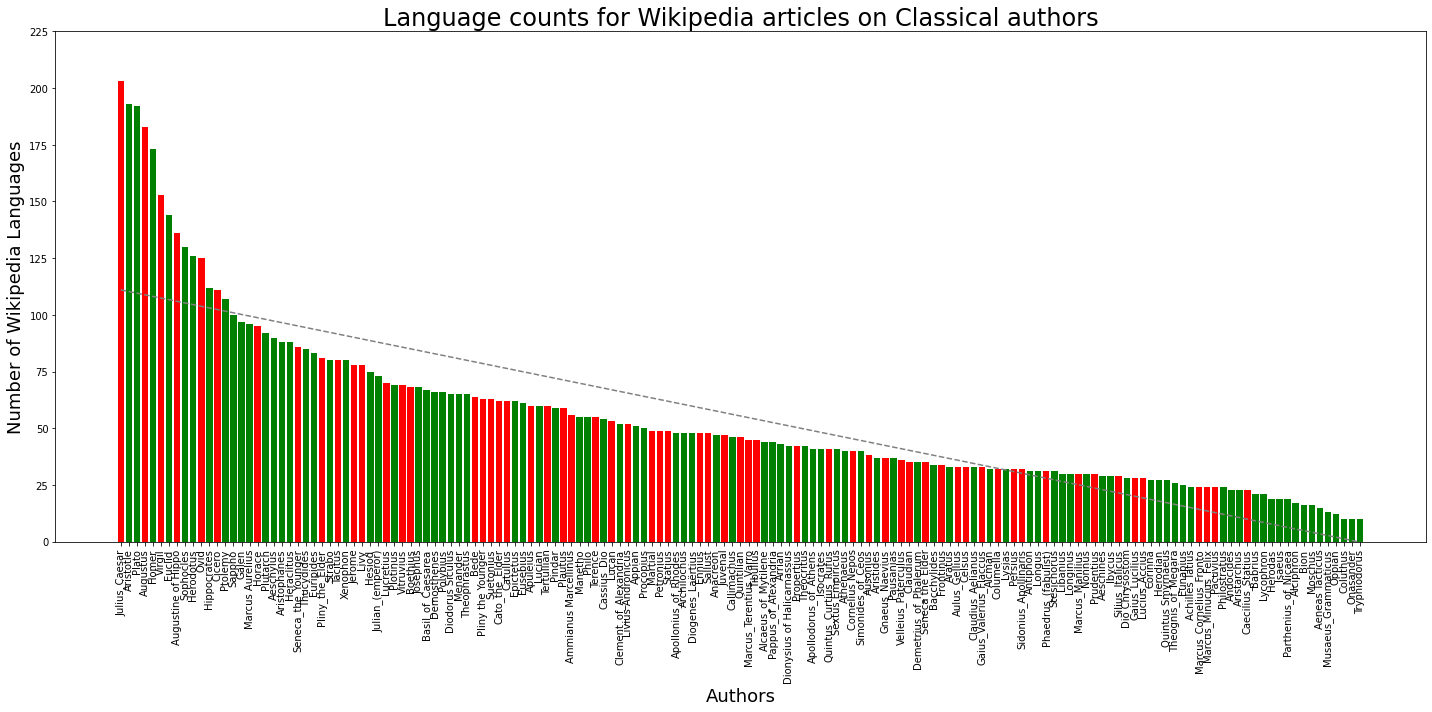

In [7]:
# Plot all authors

# sort in-place from highest to lowest
author_counts.sort(key=lambda x: x[2], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
authors = list(zip(*author_counts))[0]
lang = list(zip(*author_counts))[1]
count = list(zip(*author_counts))[2]
color_dict = {'Greek':'green', 'Latin':'red'}
x_pos = np.arange(len(authors)) 

# calculate slope and intercept for the linear trend line
slope, intercept = np.polyfit(x_pos, count, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(20,10))
plt.title('Language counts for Wikipedia articles on Classical authors', fontsize=24)
plt.plot(x_pos, trendline, color='grey', linestyle='--')
ax = plt.bar(x_pos, count, color=[color_dict[l] for l in lang])

plt.xticks(x_pos, authors, rotation='vertical') 
plt.xlabel('Authors', fontsize=18)
plt.ylabel('Number of Wikipedia Languages', fontsize=18)
plt.ylim(0, 225)
plt.tight_layout()
plt.show()

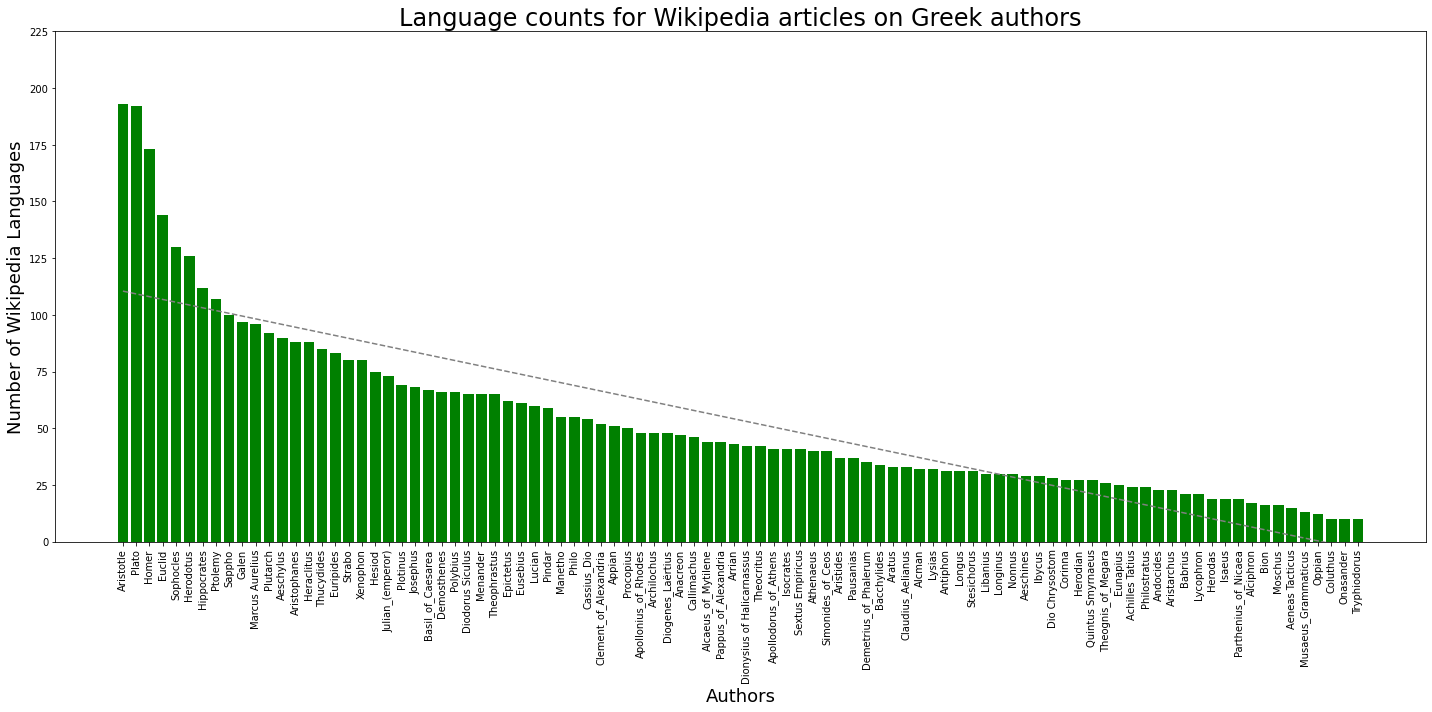

In [8]:
# Plot Greek authors authors

# sort in-place from highest to lowest
author_counts.sort(key=lambda x: x[2], reverse=True)
lang_counts = [item for item in author_counts if item[1] == 'Greek'] 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
authors = list(zip(*lang_counts))[0]
lang = list(zip(*lang_counts))[1]
count = list(zip(*lang_counts))[2]
color_dict = {'Greek':'green', 'Latin':'red'}
x_pos = np.arange(len(authors)) 

# calculate slope and intercept for the linear trend line
slope, intercept = np.polyfit(x_pos, count, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(20,10))
plt.title('Language counts for Wikipedia articles on Greek authors', fontsize=24)
plt.plot(x_pos, trendline, color='grey', linestyle='--')
ax = plt.bar(x_pos, count, color=[color_dict[l] for l in lang])

plt.xticks(x_pos, authors, rotation='vertical') 
plt.xlabel('Authors', fontsize=18)
plt.ylabel('Number of Wikipedia Languages', fontsize=18)
plt.ylim(0, 225)
plt.tight_layout()
plt.show()

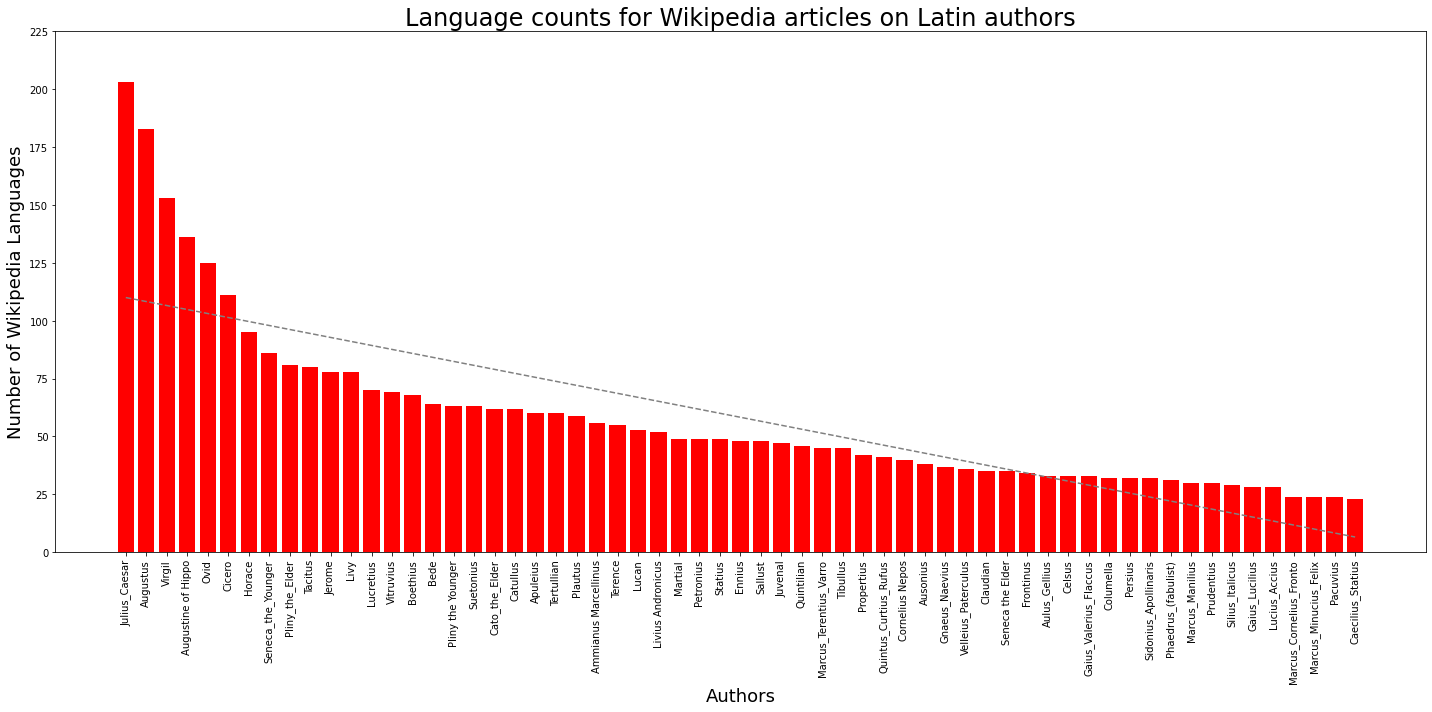

In [9]:
# Plot Latin authors

# sort in-place from highest to lowest
author_counts.sort(key=lambda x: x[2], reverse=True)
lang_counts = [item for item in author_counts if item[1] == 'Latin'] 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
authors = list(zip(*lang_counts))[0]
lang = list(zip(*lang_counts))[1]
count = list(zip(*lang_counts))[2]
color_dict = {'Greek':'green', 'Latin':'red'}
x_pos = np.arange(len(authors)) 

# calculate slope and intercept for the linear trend line
slope, intercept = np.polyfit(x_pos, count, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(20,10))
plt.title('Language counts for Wikipedia articles on Latin authors', fontsize=24)
plt.plot(x_pos, trendline, color='grey', linestyle='--')
ax = plt.bar(x_pos, count, color=[color_dict[l] for l in lang])

plt.xticks(x_pos, authors, rotation='vertical') 
plt.xlabel('Authors', fontsize=18)
plt.ylabel('Number of Wikipedia Languages', fontsize=18)
plt.ylim(0, 225)
plt.tight_layout()
plt.show()